In [ ]:
# default_exp callback.cutmixup

# CutMixUp
> fast.ai callbacks to add a combination of CutMix & MixUp, or CutMix, MixUp, & Augmentation.

In [ ]:
#export
from fastai.basics import *
from fastai.data.transforms import IntToFloatTensor, Normalize
from fastai.callback.mixup import CutMix, MixUp
from torch.distributions.beta import Beta

In [ ]:
#hide
from nbdev.showdoc import *

## CutMixUp -

In [ ]:
#export
class CutMixUp(MixUp, CutMix):
    "Combo implementation of https://arxiv.org/abs/1710.09412 and https://arxiv.org/abs/1905.04899"
    run_valid = False
    def __init__(self, mix_alpha=.4, cut_alpha=1., cutmix_ratio=1, mixup_ratio=1): 
        MixUp.__init__(self, mix_alpha)
        CutMix.__init__(self, cut_alpha)
        self.mix_distrib = Beta(tensor(mix_alpha), tensor(mix_alpha))
        self.cut_distrib = Beta(tensor(cut_alpha), tensor(cut_alpha))
        self.ratio = mixup_ratio / (cutmix_ratio + mixup_ratio)

    def before_batch(self):
        if torch.rand(1) <= self.ratio: #mixup
            self.distrib = self.mix_distrib
            MixUp.before_batch(self)
        else:
            self.distrib = self.cut_distrib
            CutMix.before_batch(self)

    def after_cancel_fit(self): # remove once MixHandler pull request is accepted
        MixUp.after_train(self) 

## CutMixUpAugment -

In [ ]:
#export
class CutMixUpAugment(MixUp, CutMix):
    "Combo implementation of https://arxiv.org/abs/1710.09412 and https://arxiv.org/abs/1905.04899 plus Augmentation"
    run_valid = False
    def __init__(self, mix_alpha=.4, cut_alpha=1., augment_ratio=1, cutmix_ratio=1, mixup_ratio=1): 
        MixUp.__init__(self, mix_alpha)
        CutMix.__init__(self, cut_alpha)
        self.mix_distrib = Beta(tensor(mix_alpha), tensor(mix_alpha))
        self.cut_distrib = Beta(tensor(cut_alpha), tensor(cut_alpha))
        self.aug_cutmix_ratio = augment_ratio / (augment_ratio + cutmix_ratio + mixup_ratio)
        if self.aug_cutmix_ratio == 1: self.cut_mix_ratio = 0
        else: self.cut_mix_ratio = mixup_ratio / (cutmix_ratio + mixup_ratio)

    def before_fit(self):
        self._inttofloat_pipe = Pipeline([])
        self._norm_pipe = Pipeline([])
        
        # first copy transforms
        self._orig_pipe = self.dls.train.after_batch
        self._orig_pipe.split_idx = 0 # need to manually set split_idx for training augmentations to run
        
        # loop through existing transforms looking for IntToFloatTensor and Normalize
        for i in range(len(self.dls.train.after_batch.fs)):
            if isinstance(self.dls.train.after_batch[i], IntToFloatTensor):
                self._inttofloat_pipe = Pipeline([self.dls.train.after_batch[i]])
            elif isinstance(self.dls.train.after_batch[i], Normalize):
                self._norm_pipe = Pipeline([self.dls.train.after_batch[i]])

        # set existing transforms to an empty Pipeline
        self.dls.train.after_batch = Pipeline([])

    def before_batch(self):
        if torch.rand(1) >= self.aug_cutmix_ratio: # augs or mixup/cutmix
            self._aug = False
            self.learn.xb = self._inttofloat_pipe(self.xb) # apply inttofloat first
            if self.cut_mix_ratio > 0 and torch.rand(1) <= self.cut_mix_ratio: # mixup or cutmix
                self.distrib = self.mix_distrib
                MixUp.before_batch(self)
            else:
                self.distrib = self.cut_distrib
                CutMix.before_batch(self)
            self.learn.xb = self._norm_pipe(self.xb) # now normalize
        else:
            self._aug = True
            self.learn.xb = self._orig_pipe(self.xb) # original transforms

    def after_fit(self):
        self.dls.train.after_batch = self._orig_pipe

    def after_cancel_fit(self):
        self.after_fit()
        MixUp.after_train(self) # change to after_cancel_fit once MixHandler pull request is accepted

    def lf(self, pred, *yb):
        if not self.training or self._aug: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

## Testing

I will use the testing method from fast.ai's [19_callback.mixup.ipynb](https://github.com/fastai/fastai/blob/master/nbs/19_callback.mixup.ipynb)

In [ ]:
#slow
from fastai.vision.all import *
from fastai.test_utils import *

# hide imported deprecation warnings from PyTorch 1.10
import warnings
warnings.filterwarnings('ignore')

def test_cutmixup(cb, dls):
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_train')
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cb.x, cb.y), ctxs=axs.flatten())

path = untar_data(URLs.PETS)
pat        = r'([^/]+)_\d+.*$'
fnames     = get_image_files(path/'images')
item_tfms  = [Resize(128, method='crop')]
batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=16, item_tfms=item_tfms, 
                                    batch_tfms=batch_tfms)

## Test CutMix

First test CutMix

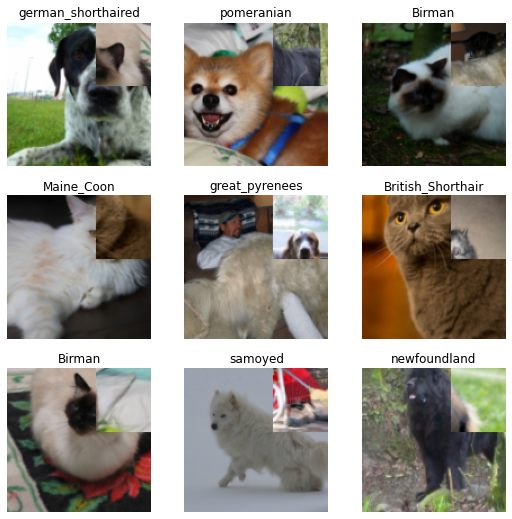

In [ ]:
#slow
cutmix = CutMixUp(cutmix_ratio=1, mixup_ratio=0)
test_cutmixup(cutmix, dls)

Then MixUp

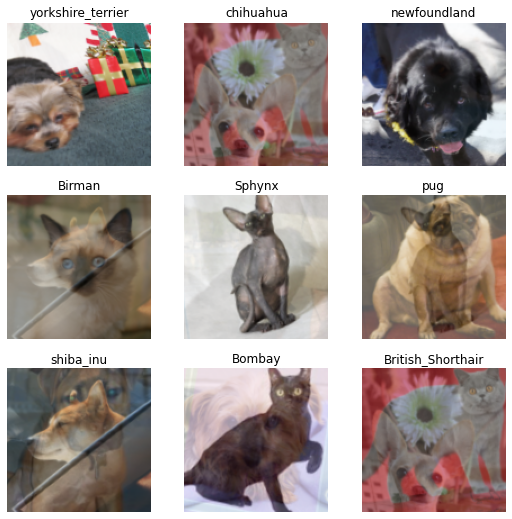

In [ ]:
#slow
mixup = CutMixUp(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1)
test_cutmixup(mixup, dls)

## Test CutMixAugment

First test CutMix

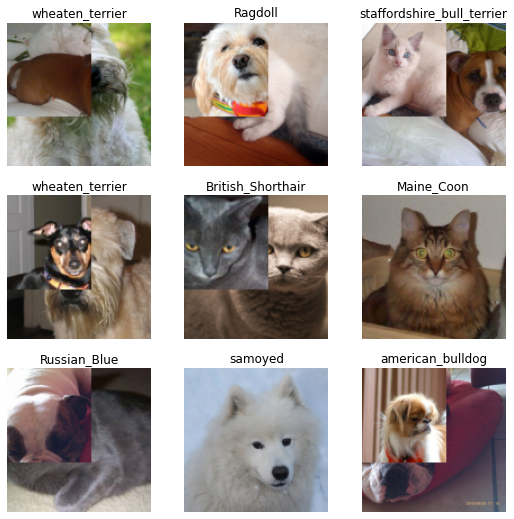

In [ ]:
#slow
cutmix = CutMixUpAugment(cutmix_ratio=1, mixup_ratio=0, augment_ratio=0)
test_cutmixup(cutmix, dls)

Then MixUp

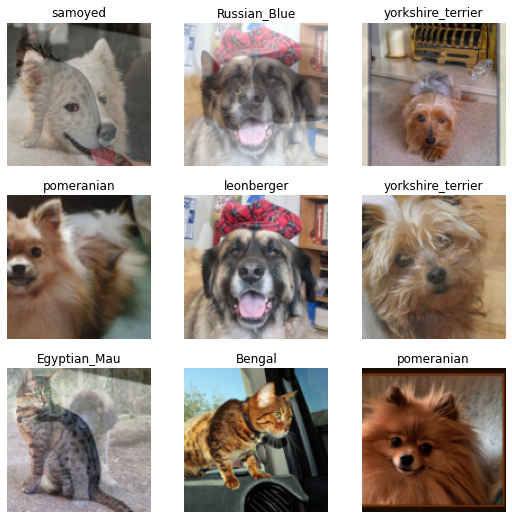

In [ ]:
#slow
mixup = CutMixUpAugment(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1, augment_ratio=0)
test_cutmixup(mixup, dls)

Finally Augmentations

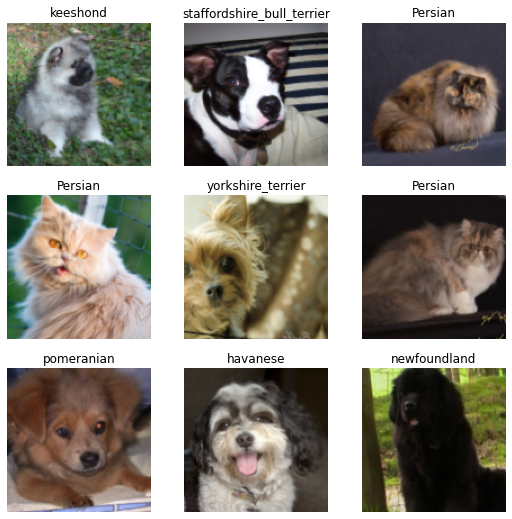

In [ ]:
#slow
augment = CutMixUpAugment(cutmix_ratio=0, mixup_ratio=0, augment_ratio=1)
test_cutmixup(augment, dls)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted augment.tensor_item_tfm.ipynb.
Converted callback.cutmixup.ipynb.
Converted index.ipynb.
Converted schedulers.fit_flat_varied.ipynb.
